# HW2 - Q2: MNIST (35 points)

**Keywords**: Multiclass Classification, Least Squares Regression, PyTorch

**About the dataset**: \
*   The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.
*   The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.
*   However because of compute limitations, we will use a much smaller dataset with size $8\times 8$ images. These images are loaded from `sklearn.datasets`.

**Agenda**:
* In this programming challenge, you will be performing multiclass classification on the simplified MNIST dataset.
* You will be applying Multiclass Logistic Regression from scratch. You will work with both Mean Square Error (L2) loss and Cross Entropy (CE) loss with gradient descent (GD) as well as stochastic/mini-batch gradient descent (SGD). 
* You will also see how using PyTorch does much of the heavylifting for modeling and training.
* Finally, you will train a 2-hidden-layer Neural Network model on the image dataset.
* All the predictions will be evaluated on a test set.

**Note:**
* Hardware accelaration is not needed but is recommended!
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters. 
  * You can also move a declared torch tensor/model to device using `.to(device)`. 
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.



---



In [74]:
# !!DO NOT EDIT!!
# imports
import torch
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# loading the dataset directly from the scikit-learn library
dataset = load_digits()
X = dataset.data
y = dataset.target
print('Number of images:', X.shape[0])
print('Number of features per image:', X.shape[1])

Number of images: 1797
Number of features per image: 64


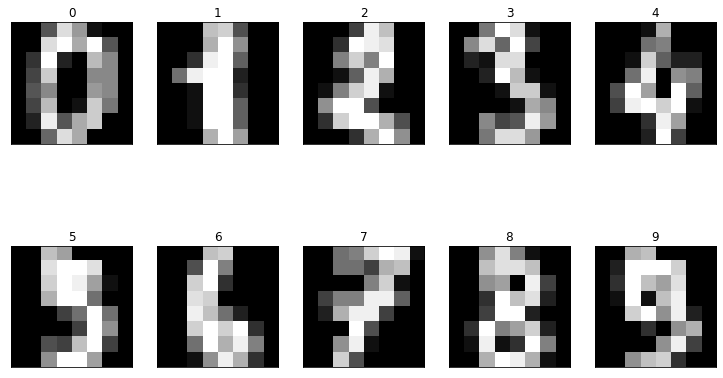

In [75]:
# !!DO NOT EDIT!!
# utility function to plot gallery of images
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# visualize some of the images of the MNIST dataset
plot_gallery(X, y, 8, 8, 2, 5)

In [76]:
# !!DO NOT EDIT!!
# Let us split the dataset into training and test sets in a stratified manner.
# Note that we are not creating evaluation datset as we will not be tuning hyper-parameters
# The split ratio is 4:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Shape of train dataset:', X_train.shape)
print('Shape of evaluation dataset:', X_test.shape)

Shape of train dataset: (1437, 64)
Shape of evaluation dataset: (360, 64)


In [77]:
# !!DO NOT EDIT!!
# define some constants - useful for later
num_classes = len(np.unique(y)) # number of target classes = 10 -- (0,1,2,3,4,5,6,7,8,9)
num_features = X.shape[1]       # number of features = 64
max_epochs = 100000             # max number of epochs for training
lr = 1e-2                       # learning rate
tolerance = 1e-6                # tolerance for early stopping during training

In [78]:
# !!DO NOT EDIT!!
# Hardware Accelaration: to set device if using GPU.
# You can change runtime in colab by naviagting to (Runtime->Change runtime type), and selecting GPU in hardware accelarator.
# NOTE that you can run this homework without GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'



---



### **(a)** In this section, we will apply multiclass logistic regression from scratch with one-vs-all strategy using gradient descent (GD) as well as stochastic gradient descent (SGD) with Mean Squared Error (MSE) loss. (8 points)
### We will be using a linear model $y^{(i)} = W \mathbf{x}^{(i)},$ where $ W_{p\times n}= \begin{bmatrix}
\leftarrow & \mathbf{w}_1^\top & \rightarrow \\
\leftarrow & \mathbf{w}_2^\top & \rightarrow\\
 & \vdots &  \\
\leftarrow & \mathbf{w}_p^\top & \rightarrow \\
\end{bmatrix}$, and $p$ is the number of target classes. Also, $\mathbf{x}^{(i)}\in \mathbb{R}^n, y^{(i)}\in \mathbb{R}$, and
### $X = \begin{bmatrix}
\uparrow &  \uparrow & \dotsm &  \uparrow\\
\mathbf{x}^{(1)} & \mathbf{x}^{(2)} & \dotsm & \mathbf{x}^{(m)} \\
\downarrow & \downarrow  & \dotsm & \downarrow  \\
\end{bmatrix}, Y = \begin{bmatrix}
y^{(1)}\\
y^{(2)} \\
\vdots \\
y^{(m)} \\
\end{bmatrix}$, where $m$ is the number of datapoints.


### **#1.** Follow the steps outlined below:

In [79]:
# 1. Scale the features between 0 and 1 
# To scale, you can directly use the MinMaxScaler from sklearn.
#######
# !!!! YOUR CODE HERE !!!!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# output variable names -  X_train, X_test
#######

In [80]:
# 2. One-Hot encode the target labels
# To one-hot encode, you can use the OneHotEncoder from sklearn
#######
# !!!! YOUR CODE HERE !!!!
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

y_train_ohe = encoder.fit_transform(y_train_reshaped)
y_test_ohe = encoder.transform(y_test_reshaped)

# output variable names -  y_train_ohe, y_test_ohe
#######
print('Shape of y_train_ohe:',y_train_ohe.shape)
print('Shape of y_test_ohe:',y_test_ohe.shape)

Shape of y_train_ohe: (1437, 10)
Shape of y_test_ohe: (360, 10)


**Note:** Here we need to define the model prediction. The input matrix is $X_{n\times m}$ where $m$ is the number of examples, and $n$ is the number of features. The linear predictions can be given by: $Y = WX + b$ where $W$ is a $p\times n$ weight matrix and $\mathbf{b}$ is a $p$ size bias vector. $p$ is the number of target labels.

### **#2.** Define a function `linear_model` that takes as input a weight matrix (`W`), bias vector (`b`), and input data matrix of size $m\times n$ (`XT`). This function should return the predictions $\hat{y}$. 

In [81]:
#######
# !!!! YOUR CODE HERE !!!!
def linear_model(W, b, XT):
  W = W.T
  y_pred = torch.mm(XT, W) + b
  return y_pred

#######

**Note:** The loss function that we would be using is the Mean Square Error (L2) Loss:\
$\displaystyle MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, where $m$ is the number of examples, $\hat{y}^{(i)}$ is the 
predicted value and $y^{(i)}$ is the ground truth.

### **#3.**Define a function `mse_loss` that takes as input prediction (`y_pred`) and actual labels (`y`), and returns the MSE loss.

In [82]:
#######
# !!!! YOUR CODE HERE !!!!
def mse_loss(y_pred, y):
  error = y_pred - y
  loss = (error ** 2).mean()
  return loss
#######

In the following part, we will do some setup required for training such as initializing weights and biases moving everything to torch tensors.

### **#4.** Define a function: `initializeWeightsAndBiases` that returns tuple `(W, b)`, where `W` is a randomly generated torch tensor of size `num_classes x num_features`, and `b` is a randomly generated torch vector of size `num_classes`. For both the tensors, set `requires_grad=True` in parameters.

### **#5.** Additionally, Move all training and testing data to torch tensors with `dtype=float32`. Remember to set `device=device` in parameters.

In [83]:
#######
# !!!! YOUR CODE HERE !!!!
def initializeWeightsAndBiases():
  W = torch.randn(num_classes, num_features, requires_grad=True, device=device )
  b = torch.randn(num_classes, requires_grad=True, device=device)
  return W, b

X_train_torch = torch.from_numpy(X_train).float().to(device)
X_test_torch = torch.from_numpy(X_test).float().to(device)
y_train_ohe_torch = torch.from_numpy(y_train_ohe).float().to(device)
y_test_ohe_torch = torch.from_numpy(y_test_ohe).float().to(device)

# output variable names -  X_train_torch, X_test_torch, y_train_ohe_torch, y_test_ohe_torch
#######

### **#6.** In this part we will implement the code for training. Given below is a function: `train_linear_regression_model` that takes as input max number of epochs (`max_epochs`), batch size (`batch_size`), Weights (`W`), Biases (`b`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). It return a tuple `(W,b,losses)` where `W,b` are the trained weigths and biases respectively, and `losses` is a list of tuples of loss logged every $100^{th}$  epoch.

Complete each of the steps outlines below. You can go through [this](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#ea0d) article for reference.

In [84]:
# Define a function train_linear_regression_model
def train_linear_regression_model(max_epochs, batch_size, W, b, X_train, y_train, lr, tolerance):
  losses = []
  prev_loss = float('inf')
  number_of_batches = math.ceil(len(X_train)/batch_size)

  for epoch in tqdm(range(max_epochs)):
    for i in range(number_of_batches):
      X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
      y_train_batch = y_train[i*batch_size: (i+1)*batch_size]
     
      #######
      # !!!! YOUR CODE HERE !!!!
      # 7. do prediction
      y_pred_batch = linear_model(W, b, X_train_batch)

      # 8. get the loss
      # loss = ______
      loss = mse_loss(y_pred_batch, y_train_batch)

      # 9. backpropagate loss
      loss.backward()

      # 10. update the weights and biasees
      with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad
      
      # 11. set the gradients to 
      W.grad.zero_()
      b.grad.zero_()
      
      #######

    # log loss every 100th epoch and print every 5000th epoch:
    if epoch%100==0:
      losses.append((epoch, loss.item()))
      if epoch%5000==0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))

    # break if decrease in loss is less than threshold
    if abs(prev_loss-loss)<=tolerance:
      break
    else:
      prev_loss=loss  

  # return updated weights, biases, and logged losses
  return W, b, losses

### **#7.** Initialize weights and biases using the `initializeWeightsAndBiases` function that you defined earlier, and train your model using function `train_linear_regression_model` defined above. Use full batch (set `batch_size=len(X_train)` for training (Gradient Descent). Also plot the graph of loss vs number of epochs (Recall that values for learning rate (`lr`) and tolerance (`tolerance`) are already defined above).

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 14.275823593139648
Epoch: 5000, Loss: 0.5161155462265015
Epoch: 10000, Loss: 0.2853960692882538
Epoch: 15000, Loss: 0.19792674481868744
Epoch: 20000, Loss: 0.15227651596069336
Epoch: 25000, Loss: 0.12424086034297943
Epoch: 30000, Loss: 0.1053338423371315
Epoch: 35000, Loss: 0.09182585775852203
Epoch: 40000, Loss: 0.08179600536823273
Epoch: 45000, Loss: 0.07413698732852936
Epoch: 50000, Loss: 0.06815899908542633


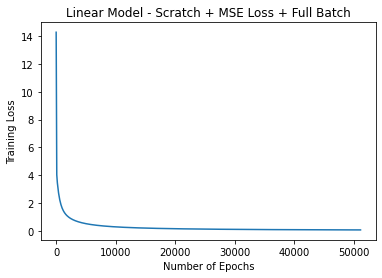

In [85]:
#######
# !!!! YOUR CODE HERE !!!!
W, b = initializeWeightsAndBiases()

W, b, losses = train_linear_regression_model(max_epochs = 100000, batch_size = len(X_train_torch), W = W, b = b, X_train = X_train_torch,
                                             y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - Scratch + MSE Loss + Full Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()

#######

In [86]:
# !!DO NOT EDIT!!
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

Train accuracy: 0.8469032707028532
Test accuracy: 0.8583333333333333


### **#8.** Now, retrain the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plot the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 10.737175941467285
Epoch: 5000, Loss: 0.038609910756349564


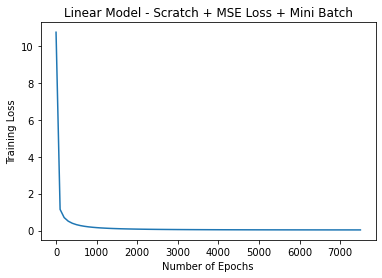

In [87]:
#######
# !!!! YOUR CODE HERE !!!!
W, b = initializeWeightsAndBiases()

W, b, losses = train_linear_regression_model(max_epochs = 100000, batch_size = 64, W = W, b = b, X_train = X_train_torch,
                                             y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - Scratch + MSE Loss + Mini Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()

#######

In [88]:
# !!DO NOT EDIT!!
# print accuracies of model
predictions_train = linear_model(W,b,X_train_torch).to('cpu')
predictions_test = linear_model(W,b,X_test_torch).to('cpu')
y_train_pred = torch.argmax(predictions_train, dim=1).numpy()

y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

Train accuracy: 0.9366736256089074
Test accuracy: 0.9277777777777778




---



### **(b)** In the previous question, we defined the model, loss, and even the gradient update step. We also had to manully set the grad to zero. In this question, we will re-implement the linear model and see how we can directly use Pytorch to do all this for us in a few simple steps. (6 points)

In [89]:
# !! DO NOT EDIT !!
# common utility function to print accuracies
def print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test):
  predictions_train = model(X_train_torch).to('cpu')
  predictions_test = model(X_test_torch).to('cpu')
  y_train_pred = torch.argmax(predictions_train, dim=1).numpy()
  y_test_pred = torch.argmax(predictions_test, dim=1).numpy()
  print("Train accuracy:",accuracy_score(y_train_pred, np.asarray(y_train, dtype=np.float32)))
  print("Test accuracy:",accuracy_score(y_test_pred, np.asarray(y_test, dtype=np.float32)))

### **#1.** Define the linear model using PyTorch

In [90]:
#######
# !!!! YOUR CODE HERE !!!!
import torch.nn as nn
# Define a model class using torch.nn
class Linear_Model(torch.nn.Module):
  def __init__(self):
    super(Linear_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialze one linear layer: num_features -> num_targets
    self.linear = nn.Linear(num_features, num_classes)

  def forward(self, X):
    # 2. define the feedforward algorithm of the model and return the final output
    return self.linear(X)

#######

### **#2.** In this part we will implement a general function for training a PyTorch model. Define a general training function: `train_torch_model` that takes as input an initialized torch model (`model`), batch size (`batch_size`), initialized loss (`criterion`), max number of epochs (`max_epochs`), training data (`X_train, y_train`), learning rate (`lr`), tolerance for stopping (`tolerance`). This function will return a tuple `(model, losses)`, where `model` is the trained model, and `losses` is a list of tuples of loss logged every $100^{th}$ epoch. Complete each of the steps outlines below. You can go through [this](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#ea0d) article for reference.  You can also refer Q3-(d) from HW1.

In [91]:
# Define a function train_torch_model
def train_torch_model(model, batch_size, criterion, max_epochs, X_train, y_train, lr, tolerance):
  losses = []
  prev_loss = float('inf')
  number_of_batches = math.ceil(len(X_train)/batch_size)
  
  #######
  # !!!! YOUR CODE HERE !!!!
  # 3. move model to device
  model = model.to(device)

  # 4. define optimizer (use torch.optim.SGD (Stochastic Gradient Descent)) 
  # Set learning rate to lr and also set model parameters
  optimizer = torch.optim.SGD(model.parameters(), lr = lr) 

  for epoch in tqdm(range(max_epochs)):
    for i in range(number_of_batches):
      X_train_batch = X_train[i*batch_size: (i+1)*batch_size]
      y_train_batch = y_train[i*batch_size: (i+1)*batch_size]

      # 5. reset gradients
      optimizer.zero_grad()

      # 6. prediction
      y_pred_batch = model(X_train_batch)

      # 7. calculate loss
      loss = criterion(y_pred_batch, y_train_batch)

      # 8. backpropagate loss
      loss.backward()

      # 9. perform a single gradient update step
      optimizer.step()

  #######

    # log loss every 100th epoch and print every 5000th epoch:
    if epoch%100==0:
      losses.append((epoch, loss.item()))
      if epoch%5000==0:
        print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
    
    # break if decrease in loss is less than threshold
    if abs(prev_loss-loss)<=tolerance:
      break
    else:
      prev_loss=loss  

  # return updated model and logged losses
  return model, losses

### **#3.** Initialize your model and loss function. Use `nn.MSELoss`. Use full batch for training (Gradient Descent). Also plot the graph of loss vs number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.18567894399166107
Epoch: 5000, Loss: 0.03936692699790001


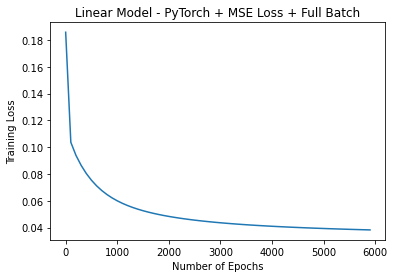

In [92]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = nn.MSELoss()

model, losses = train_torch_model(model = model, batch_size = len(X_train_torch), criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - PyTorch + MSE Loss + Full Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()


#######

In [93]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9311064718162839
Test accuracy: 0.9388888888888889


### **#4.** Now, retrain the above model with `batch_size=64` (Stochastic/Mini-batch Gradient Descent) keeping else everything same. Like before, plot the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.14009779691696167


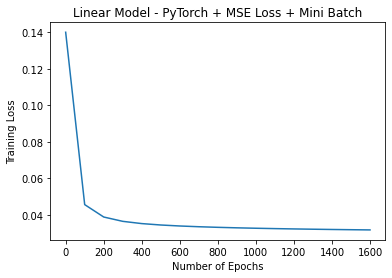

In [94]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = nn.MSELoss()

model, losses = train_torch_model(model = model, batch_size = 64, criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - PyTorch + MSE Loss + Mini Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()

#######

In [95]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.942936673625609
Test accuracy: 0.9472222222222222




---



### **(c)** Now, instead of using MSELoss, we will use a much more natural loss function for logistic regression task which is the Cross Entropy Loss. (8 points)
**Note:**
The [Cross Entropy Loss](https://ebookreading.net/view/book/EB9781789130331_73.html) for multiclass calssification is the mean of the negative log likelihood of the output logits after softmax:\
$L = \underbrace{\frac{1}{m} \sum_{i=1}^m \underbrace{-y^{(i)} \underbrace{log \underbrace{\frac{e^{\hat{y}^{(i)}}}{\sum_{j=1}^p e^{\hat{y}^{(j)}}}}_{\text{Softmax}}}_{\text{LogSoftmax}}}_{\text{Negative Log Likelihood (NLL)}}}_{\text{Cross Entropy (CE) Loss }}$,


where $y^{(i)}$ is the ground truth, and $\hat{y}^{(k)}$ (also called as *logits*) represent the outputs of the last linear layer of the model. 

### **#1.** Instead of `nn.MSELoss`, train the above model with `nn.CrossEntropyLoss`. Use full-batch. Also plot the graph between loss and number of epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.329389810562134
Epoch: 5000, Loss: 0.4083782136440277
Epoch: 10000, Loss: 0.2738310396671295
Epoch: 15000, Loss: 0.22050286829471588
Epoch: 20000, Loss: 0.1902814507484436
Epoch: 25000, Loss: 0.17017532885074615
Epoch: 30000, Loss: 0.15550784766674042
Epoch: 35000, Loss: 0.1441514790058136
Epoch: 40000, Loss: 0.1349867731332779
Epoch: 45000, Loss: 0.12736265361309052
Epoch: 50000, Loss: 0.120871901512146
Epoch: 55000, Loss: 0.11524518579244614


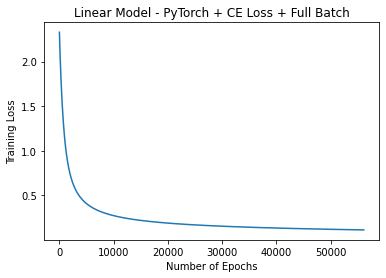

In [96]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = nn.CrossEntropyLoss()

model, losses = train_torch_model(model = model, batch_size = len(X_train_torch), criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - PyTorch + CE Loss + Full Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()

#######

In [97]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9805149617258176
Test accuracy: 0.9666666666666667


### **#2.** Perform the same task above with `batch_size=64`. Also plot the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3292059898376465
Epoch: 5000, Loss: 0.08683190494775772
Epoch: 10000, Loss: 0.06100000813603401
Epoch: 15000, Loss: 0.04834204539656639
Epoch: 20000, Loss: 0.04052439332008362


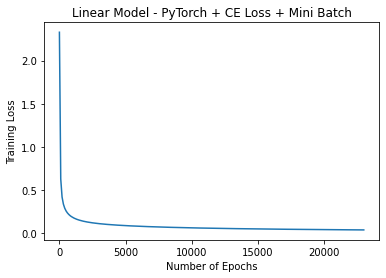

In [98]:
#######
# !!!! YOUR CODE HERE !!!!
model = Linear_Model()
criterion = nn.CrossEntropyLoss()

model, losses = train_torch_model(model = model, batch_size = 64, criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("Linear Model - PyTorch + CE Loss + Mini Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()
#######

In [99]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9979123173277662
Test accuracy: 0.9694444444444444




---



### **(d)** Now, we will train a neural network in pytorch with two hidden layers of sizes 32 and 16 neurons. We will use non-linear ReLU activations thus effectively making this a non-linear model. We will use this neural network model for multi-class classification with Cross Entropy Loss. (8 points)

**Note:** The neural network model output can be represented mathematically as below:\
$\hat{y}^{(i)}_{10\times1} = W^{(3)}_{10\times 16}\sigma(W^{(2)}_{16\times 32}\sigma(W^{(1)}_{32\times 64}\mathbf{x}^{(i)}_{64\times1}+\mathbf{b}^{(1)}_{32\times1})+\mathbf{b}^{(2)}_{16\times1})+\mathbf{b}^{(3)}_{10\times1}$, \
where $\sigma$ represents ReLU activation, $W^{(i)}$ is the weight of the $i^{th}$ linear layer, and $\mathbf{b}^{(i)}$ is the layer's bias. We use the subscript to denote the dimension for clarity. 

### **#1.** Define the 2-hidden layer neural network model below.

In [100]:
#######
# !!!! YOUR CODE HERE !!!!
# Define a neural network model class using torch.nn
class NN_Model(torch.nn.Module):
  def __init__(self):
    super(NN_Model, self).__init__()
    # Initalize various layers of model as instructed below
    # 1. initialize three linear layers: num_features -> 32, 32 -> 16, 16 -> num_targets
    self.linear1 = nn.Linear(num_features, 32)
    self.linear2 = nn.Linear(32, 16)
    self.linear3 = nn.Linear(16, num_classes)

    # 2. initialize RELU
    self.relu = nn.ReLU()    

  def forward(self, X):
    # 3. define the feedforward algorithm of the model and return the final output
    # Apply non-linear ReLU activation between subsequent layers
    activation1 = self.relu(self.linear1(X))
    activation2 = self.relu(self.linear2(activation1))
    output = self.linear3(activation2)
    return output

#######  

### **#2.** Train the newly defined Neural Network two hidden layer model with Cross Entropy Loss. Use full-batch and plot the graph of loss vs number of epochs. Note that you can re-use the training function `train_torch_model` (from part (b)).

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.3094677925109863
Epoch: 5000, Loss: 0.1817384660243988
Epoch: 10000, Loss: 0.0782303586602211
Epoch: 15000, Loss: 0.04346810281276703
Epoch: 20000, Loss: 0.027297910302877426
Epoch: 25000, Loss: 0.018533818423748016


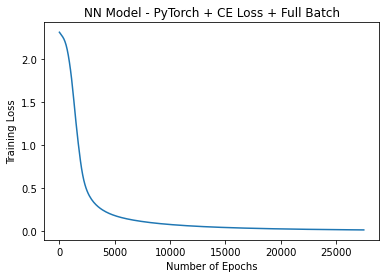

In [101]:
#######
# !!!! YOUR CODE HERE !!!!
model = NN_Model()
criterion = nn.CrossEntropyLoss()

model, losses = train_torch_model(model = model, batch_size = len(X_train_torch), criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("NN Model - PyTorch + CE Loss + Full Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()
#######

In [102]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9993041057759221
Test accuracy: 0.9611111111111111


### **#3.** Re-train the above model with `batch_size=64`. Also plot the graph of loss vs epochs.

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 0, Loss: 2.259671688079834


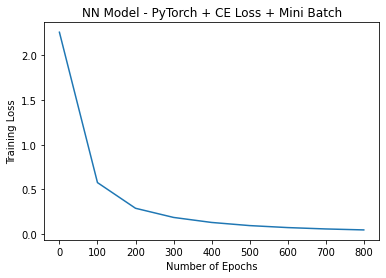

In [103]:
#######
# !!!! YOUR CODE HERE !!!!
model = NN_Model()
criterion = nn.CrossEntropyLoss()

model, losses = train_torch_model(model = model, batch_size = 64, criterion = criterion, max_epochs = 100000,
                                  X_train = X_train_torch, y_train = y_train_ohe_torch, lr = lr, tolerance = tolerance)

# Plotting loss vs no of epochs graph
epoch_list = []
loss_list = []
for data in losses:
  epoch_list.append(data[0])
  loss_list.append(data[1])

plt.title("NN Model - PyTorch + CE Loss + Mini Batch")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.plot(epoch_list, loss_list)
plt.show()

#######

In [104]:
# !!DO NOT EDIT!!
# print accuracies of model
print_accuracies_torch(model, X_train_torch, X_test_torch, y_train, y_test)

Train accuracy: 0.9958246346555324
Test accuracy: 0.9638888888888889




---



### **(e)**  In the above few problems, you performed several experiments with different batch size and loss functions. Write down an analysis of your observations from the results. (5 points)
Some points that you could cover are:
* Effect of using full vs. batch gradient descent.
* Effect of different loss strategy on performance.
* Effect of using linear vs. non-linear models.
* Training time per epoch in different cases.

Also, plot a line graph of accuracy vs. model for both train and test sets. Recall that you trained the following models in this question:

1.   Linear Model - Scratch + MSE Loss + Full Batch 
2.   Linear Model - Scratch + MSE Loss + Mini Batch 
3.   Linear Model - PyTorch + MSE Loss + Full Batch 
4.   Linear Model - PyTorch + MSE Loss + Mini Batch 
5.   Linear Model - PyTorch + CE Loss + Full Batch 
6.   Linear Model - PyTorch + CE Loss + Mini Batch 
7.   NN Model - PyTorch + CE Loss + Full Batch 
8.   NN Model - PyTorch + CE Loss + Mini Batch 


#### <font color="red">Your answer here:</font>
**Analysis of models:**

Note - Accuracies are not included in this table because they have been plotted in the graphs below.

|Model|Gradient Descent Type|Training Runtime|Iterations per sec| Epochs for Convergence|Time per epoch (ms)|
|------------------------------------|----------|---|-------|------|-----|
|1. Linear Model - Scratch + MSE Loss|Full Batch|33 |1507.65|51,147|0.66 |
|2. Linear Model - Scratch + MSE Loss|Mini Batch|95 |80.16  |7,598 |12.50|
|3. Linear Model - PyTorch + MSE Loss|Full Batch|4  |1474.63|5,966 |0.68 | 
|4. Linear Model - PyTorch + MSE Loss|Mini Batch|22 |76.27  |1,692 |13.11|
|5. Linear Model - PyTorch + CE Loss |Full Batch|43 |1302.27|56,197|0.77 |
|6. Linear Model - PyTorch + CE Loss |Mini Batch|345|66.19  |23,067|15.11| 
|7. NN Model - PyTorch + CE Loss     |Full Batch|42 |700.95 |27,549|1.42 | 
|8. NN Model - PyTorch + CE Loss     |Mini Batch|20 |40.07  |817   |24.96| 

**1. Effect of using full vs. batch gradient descent:** 
Using mini batch gardient descent improves the testing accuracy in all cases over full batch gradient descent. It also improved the training accuracy in all cases, except in NN model-PyTorch + CE Loss, in which the training accuracy was already extremely high (99.93%). Hence, we can conclude that mini batch gradient descent is definitely better than full batch gradient descent for achieving a more accurate model.

Mini batch gradient descent also significantly reduced the number of epochs needed for convergence as compared to full batch. However, it takes significantly more time to train in all cases too, except in NN model-PyTorch + CE Loss. The number of iterations per second are also way lesser in mini batch. 



**2. Effect of different loss strategy on performance:**
For Linear Model - PyTorch, we use both CE and MSE Loss. Using CE loss not only significantly increases training and testing accuracies, but increases number of epochs needed for convergence, increases training runtime and decreases number of iterations per second. In some linear models, MSE loss leads to slight overfitting in which the test error is slightly greater than the training error.

**3.Effect of using linear vs. non-linear models:**
Non-linear models have higher testing and training accuracies than all linear models except Linear - PyTorch + CE Loss + Mini Batch. The non-linear models have lesser iterations per second than the linear models and higher time per epoch. The Mini batch non-linear model takes the fewest number of epochs to converge. In general the non-linear models are more accurate, but slower to train.

**4. Training time per epoch in different cases:**
Training timer per epoch is lower in full batch, MSE loss and linear models as compared to mini batch, CE loss and non-linear models. Linear Model - Scratch + MSE + Full Batch has the minimum training time per epoch (0.66ms) where as NN Model - PyTorch + CSE + Mini Batch has the maximum training time per epoch (24.96ms). As the model gets more complex, training time per epoch increases.

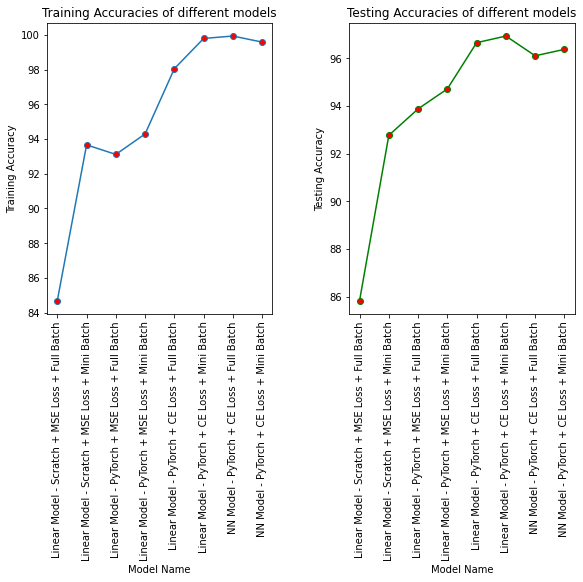

In [142]:
# plotting graph of accuracy vs. model for both train and test sets for all 8 models
%matplotlib inline
modelList = ['Linear Model - Scratch + MSE Loss + Full Batch',
             'Linear Model - Scratch + MSE Loss + Mini Batch',
             'Linear Model - PyTorch + MSE Loss + Full Batch',
             'Linear Model - PyTorch + MSE Loss + Mini Batch',
             'Linear Model - PyTorch + CE Loss + Full Batch',
             'Linear Model - PyTorch + CE Loss + Mini Batch',
             'NN Model - PyTorch + CE Loss + Full Batch',
             'NN Model - PyTorch + CE Loss + Mini Batch']

trainAccuracyList = [84.69, 93.66, 93.11, 94.29, 98.05, 99.79, 99.93, 99.58]
testAccuracyList = [85.83, 92.77, 93.88, 94.72, 96.66, 96.94, 96.11, 96.38]

f = plt.figure(figsize=(9,9))
plt.subplot(1, 2, 1) 
plt.title("Training Accuracies of different models")
plt.xlabel("Model Name")
plt.ylabel("Training Accuracy")
plt.plot(modelList, trainAccuracyList, marker = 'o',
         markerfacecolor = 'red')
plt.xticks(rotation = 90)

plt.subplot(1, 2, 2) 
plt.title("Testing Accuracies of different models")
plt.xlabel("Model Name")
plt.ylabel("Testing Accuracy")
plt.plot(modelList, testAccuracyList, color = 'green', marker = 'o',
         markerfacecolor = 'red')
plt.xticks(rotation = 90)
plt.tight_layout(4)

plt.show()




---



---

